# TP1 - EJERCICIO 3

**INTEGRANTES:**
* AGUSTIN ARENAS
* SOL KIDONAKIS


**AÑO:** 2024

## BIBLIOTECAS

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

from pathlib import Path
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

In [4]:
#!pip install --upgrade tensorflow keras

In [5]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## PROBLEMA 3

### ANALISIS EXPLORATORIO Y PREPROCESAMIENTO DEL SET DE DATOS

In [7]:
# Directorios del dataset
# SK
#TRAIN_DATA_DIRECTORY = Path("/content/drive/MyDrive/AA2/TP1-3-natural-scenes/seg_train/seg_train")
#VALIDATION_DATA_DIRECTORY = Path("/content/drive/MyDrive/AA2/TP1-3-natural-scenes/seg_test/seg_test")
#PREDICTION_DATA_DIRECTORY = Path("/content/drive/MyDrive/AA2/TP1-3-natural-scenes/seg_pred/seg_pred")

# AA
TRAIN_DATA_DIRECTORY = Path("/content/drive/MyDrive/TUIA/AAII/TP1-3-natural-scenes/seg_train/seg_train")
VALIDATION_DATA_DIRECTORY = Path("/content/drive/MyDrive/TUIA/AAII/TP1-3-natural-scenes/seg_test/seg_test")
PREDICTION_DATA_DIRECTORY = Path("/content/drive/MyDrive/TUIA/AAII/TP1-3-natural-scenes/seg_pred/seg_pred")

# AA Local
#TRAIN_DATA_DIRECTORY = Path("TP1-3-natural-scenes/seg_train/seg_train")
#VALIDATION_DATA_DIRECTORY = Path("TP1-3-natural-scenes/seg_test/seg_test")
#PREDICTION_DATA_DIRECTORY = Path("TP1-3-natural-scenes/seg_pred/seg_pred")

# Tamaño del lote (batch size)
BATCH_SIZE = 500
IMAGE_HEIGHT = 150 #150
IMAGE_WIDTH = 150 #150

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIRECTORY,
    label_mode="categorical",  # Asigna las etiquetas basadas en las carpetas
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    seed=123,
    validation_split=0.75,  # Tomamos el proporcional
    subset="validation",
    shuffle=False
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    seed=123,
    validation_split=0.75,  # Tomamos el proporcional
    subset="validation",
    shuffle=False
)

# Carga los datos de predicción (sin etiquetas)
prediction_ds = tf.keras.utils.image_dataset_from_directory(
    PREDICTION_DATA_DIRECTORY,
    label_mode=None,  # Sin etiquetas porque es para predicción
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    seed=123,
    shuffle=False  # No mezclar para mantener el orden
)


Found 14034 files belonging to 6 classes.
Using 10525 files for validation.
Found 3000 files belonging to 6 classes.
Using 2250 files for validation.
Found 7301 files.


In [8]:
# Clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Visualizar los datos:

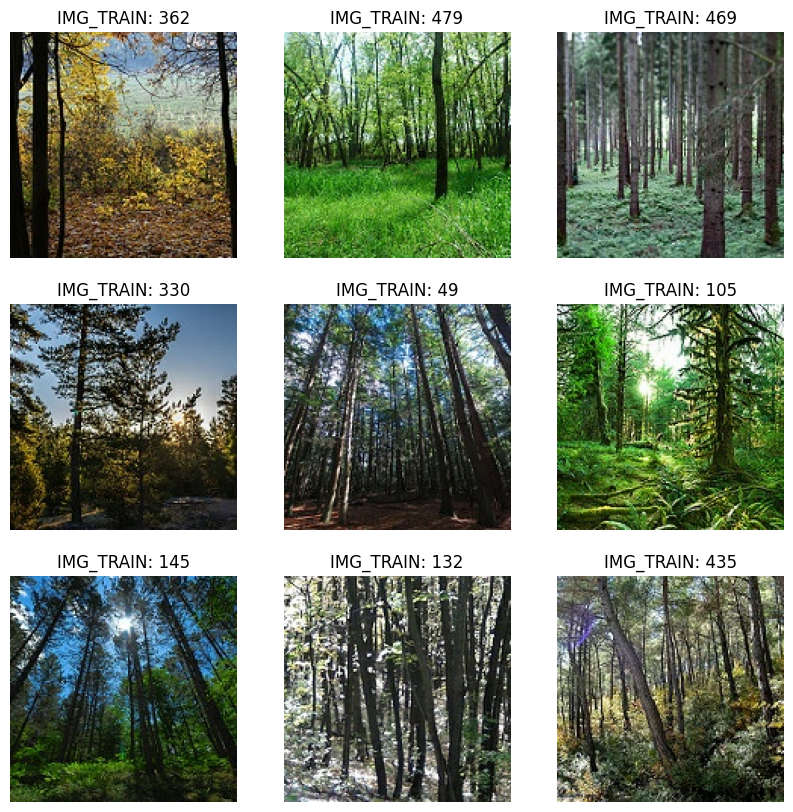

In [22]:
plt.figure(figsize=(10, 10))
for batch in train_ds.take(1):  # Toma un lote
    images, labels = batch  # Separa las imágenes de las etiquetas
    random_indices = np.random.choice(len(images), 9, replace=False)  # Selecciona 9 índices aleatorios sin reemplazo
    for i, idx in enumerate(random_indices):  # Itera sobre índices aleatorios
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx].numpy().astype("uint8"))  # Convierte a uint8 para mostrar
        plt.title(f"IMG_TRAIN: {idx}")
        plt.axis("off")

### DEFINICION Y ENTRENAMIENTO DEL MODELO

Función para plotear el entrenamiento de los modelos

In [10]:
def plot_history(history, title):
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.title(title)
    plt.legend()
    plt.show()

#### **Modelo con Capas Densas**

In [ ]:
dense_model = models.Sequential([
    layers.Flatten(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    layers.Dropout(0.2),
    layers.Dense(963, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(369, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

dense_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

dense_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 963)                 │      65,003,463 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 963)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 369)                 │         355,716 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 369)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │           2,220 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,361,399 (249.33 MB)

 Trainable params: 65,361,399 (249.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping para detener el entrenamiento cuando la validación deje de mejorar
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Entrenamos el modelo
history_dense = dense_model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1998s 95s/step - accuracy: 0.4144 - loss: 28442.0352 - val_accuracy: 0.2227 - val_loss: 31447.1113
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - accuracy: 0.0066 - loss: 34644.3398 - val_accuracy: 0.2267 - val_loss: 3738.6213
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 125s 6s/step - accuracy: 0.0744 - loss: 2733.3230 - val_accuracy: 0.2413 - val_loss: 61.4231
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - accuracy: 0.0247 - loss: 51.2827 - val_accuracy: 0.2333 - val_loss: 1.7848
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 132s 6s/step - accuracy: 0.0860 - loss: 1.8104 - val_accuracy: 0.2333 - val_loss: 1.7673
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - accuracy: 0.1013 - loss: 1.7874 - val_accuracy: 0.2333 - val_loss: 1.7565
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step - accuracy: 0.1083 - loss: 1.7986 - val_accuracy: 0.2333 - val_loss: 1.7472
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 147s 6s/step - accuracy: 0.1075 - loss: 1.7850 - va

In [ ]:
# Evaluamos el modelo
dense_loss, dense_acc = dense_model.evaluate(val_ds)
print(f"Precisión del modelo denso en validación: {dense_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.2275 - loss: 1.7377
Precisión del modelo denso en validación: 0.23333333432674408


Predecir en nuevas imágenes:

In [ ]:
# Predicción
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # 3 filas y 5 columnas para mostrar 15 imágenes

# Usamos 15 imágenes del dataset de predicción
for i, images in enumerate(prediction_ds.take(15)):  # Tomamos 15 imágenes para predecir (sin etiquetas)
    # IMG
    image = images[0].numpy().astype("uint8")  # Convierte la imagen a formato visualizable
    ax = axes[i // 5, i % 5]  # Ubicación en la cuadrícula 3x5
    ax.imshow(image)
    ax.axis('off')

    # Expande la dimensión para predecir
    image_for_prediction = np.expand_dims(image, axis=0)

    # Predicción del modelo
    prediction = dense_model.predict(image_for_prediction)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Display result
    ax.set_title(f"Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### **Modelo con Capas Convolucionales y Densas**

In [ ]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping para detener el entrenamiento cuando la validación deje de mejorar
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Entrenar el modelo CNN
history_cnn = cnn_model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 575s 26s/step - accuracy: 0.4716 - loss: 41.6216 - val_accuracy: 0.2227 - val_loss: 7.4396
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 663s 28s/step - accuracy: 0.2461 - loss: 2.9844 - val_accuracy: 0.2227 - val_loss: 119.0535
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 582s 26s/step - accuracy: 0.2286 - loss: 34.0795 - val_accuracy: 0.2227 - val_loss: 113.6182
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 617s 26s/step - accuracy: 0.2055 - loss: 33.4832 - val_accuracy: 0.2227 - val_loss: 61.1306


In [ ]:
# Evaluamos el modelo
cnn_loss, cnn_acc = cnn_model.evaluate(val_ds)
print(f"Precisión del modelo CNN en validación: {cnn_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.0951 - loss: 9.1622
Precisión del modelo CNN en validación: 0.2226666659116745


Predecir en nuevas imágenes:

In [ ]:
# Predicción
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # 3 filas y 5 columnas para mostrar 15 imágenes

# Usamos 15 imágenes del dataset de predicción
for i, images in enumerate(prediction_ds.take(15)):  # Tomamos 15 imágenes para predecir (sin etiquetas)
    # IMG
    image = images[0].numpy().astype("uint8")  # Convierte la imagen a formato visualizable
    ax = axes[i // 5, i % 5]  # Ubicación en la cuadrícula 3x5
    ax.imshow(image)
    ax.axis('off')

    # Expande la dimensión para predecir
    image_for_prediction = np.expand_dims(image, axis=0)

    # Predicción del modelo
    prediction = cnn_model.predict(image_for_prediction)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Display result
    ax.set_title(f"Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### **Modelo con Bloques Residuales (ResNet)**

In [11]:
class ResidualBlock(tf.keras.Model):
    def __init__(self, filters, use_projection=False):
        super(ResidualBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, kernel_size=(3,3), padding="same")
        self.bn1 = layers.BatchNormalization()

        self.conv2 = layers.Conv2D(filters, kernel_size=(3,3), padding="same")
        self.bn2 = layers.BatchNormalization()

        # Proyección en la conexión de salto si las dimensiones no coinciden
        self.use_projection = use_projection
        if use_projection:
            self.projection = layers.Conv2D(filters, kernel_size=(1, 1), padding="same")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        # Proyectar la entrada para que coincida en dimensiones si es necesario
        if self.use_projection:
            inputs = self.projection(inputs)

        # Sumar la entrada original (o ajustada) a la salida del bloque residual
        return tf.nn.relu(x + inputs)


In [12]:
residual_model = models.Sequential([
    # Primer bloque convolucional
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),

    # Primer bloque residual sin proyección (las dimensiones coinciden, ambos son 64 filtros)
    ResidualBlock(64, use_projection=False),

    layers.MaxPooling2D((2, 2)),

    # Segundo bloque residual con proyección (cambio de 64 a 128 filtros)
    ResidualBlock(128, use_projection=True),

    layers.MaxPooling2D((2, 2)),

    # Tercer bloque residual con proyección (cambio de 128 a 256 filtros)
    ResidualBlock(256, use_projection=True),

    layers.Flatten(),
    layers.Dense(123, activation='relu'), #256
    layers.Dense(num_classes, activation='softmax')
])

# Compilar el modelo
residual_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Mostrar la arquitectura del modelo
residual_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ (None, 74, 74, 64)          │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_1 (ResidualBlock)     │ (None, 37, 37, 128)         │         230,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_2 (ResidualBlock)     │ (None, 18, 18, 256)         │         920,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 123)                 │      10,202,235 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             744 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,430,243 (43.60 MB)

 Trainable params: 11,428,451 (43.60 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [13]:
# Early stopping para detener el entrenamiento cuando la validación deje de mejorar
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [14]:
# Entrenar el modelo
history_residual = residual_model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2464s 112s/step - accuracy: 0.2907 - loss: 419.9200 - val_accuracy: 0.2387 - val_loss: 297.9354
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2156s 98s/step - accuracy: 0.4042 - loss: 12.4374 - val_accuracy: 0.2262 - val_loss: 88.7344
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2196s 98s/step - accuracy: 0.1183 - loss: 8.6013 - val_accuracy: 0.1889 - val_loss: 16.2392
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2177s 98s/step - accuracy: 0.0794 - loss: 3.9664 - val_accuracy: 0.2631 - val_loss: 1.6749
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2394s 108s/step - accuracy: 0.1248 - loss: 1.8048 - val_accuracy: 0.3849 - val_loss: 1.5894
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2549s 114s/step - accuracy: 0.1830 - loss: 1.7007 - val_accuracy: 0.2329 - val_loss: 2.5526
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2528s 113s/step - accuracy: 0.2969 - loss: 2.2102 - val_accuracy: 0.1778 - val_loss: 1.9504
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2528s 114s/step - accuracy: 0.5026 - loss: 2.098

In [17]:
# Evaluar el modelo en el conjunto de validación
residual_loss, residual_acc = residual_model.evaluate(val_ds)
print(f"Precisión del modelo con Bloques residuales en validación: {residual_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 137s 25s/step - accuracy: 0.3147 - loss: 1.6976
Precisión del modelo con Bloques residuales en validación: 0.3848888874053955


Predecir en nuevas imágenes:

In [18]:
# Predicción
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # 3 filas y 5 columnas para mostrar 15 imágenes

# Usamos 15 imágenes del dataset de predicción
for i, images in enumerate(prediction_ds.take(15)):  # Tomamos 15 imágenes para predecir (sin etiquetas)
    # IMG
    image = images[0].numpy().astype("uint8")  # Convierte la imagen a formato visualizable
    ax = axes[i // 5, i % 5]  # Ubicación en la cuadrícula 3x5
    ax.imshow(image)
    ax.axis('off')

    # Expande la dimensión para predecir
    image_for_prediction = np.expand_dims(image, axis=0)

    # Predicción del modelo
    prediction = residual_model.predict(image_for_prediction)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Display result
    ax.set_title(f"Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### **Modelo con Transfer Learning**

In [ ]:
# Verificar la forma de las imágenes
for images, labels in train_ds.take(1):
    print(f"Tamaño de las imágenes: {images.shape}")
    print(f"Tamaño de las etiquetas: {labels.shape}")

Tamaño de las imágenes: (500, 150, 150, 3)
Tamaño de las etiquetas: (500, 6)


In [ ]:
# Cargar el modelo preentrenado VGG16 sin las capas superiores
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# Congelar las capas del modelo base
base_model.trainable = False

num_classes = 6

# Crear el modelo completo
# Añadir una capa de entrada para definir explícitamente la forma de entrada
input_tensor = layers.Input(shape=(150, 150, 3))
x = base_model(input_tensor)  # Pasar la entrada a través del modelo base
x = layers.GlobalAveragePooling2D()(x)     # Pooling global para reducir la dimensionalidad
x = layers.Dense(123, activation='relu')(x) # Capa densa intermedia
output_tensor = layers.Dense(num_classes, activation='softmax')(x)  # Capa de salida

# Crear el modelo final
transfer_model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

# Compilar el modelo
transfer_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Verificar la arquitectura del modelo completo
transfer_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 123)                 │          63,099 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             744 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,778,531 (56.38 MB)

 Trainable params: 63,843 (249.39 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Early stopping para detener el entrenamiento cuando la validación deje de mejorar
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Entrenar el modelo
history_transfer = transfer_model.fit(
    train_ds,               # Conjunto de entrenamiento
    validation_data=val_ds, # Conjunto de validación
    epochs=10,
    callbacks=[early_stopping])

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3796s 174s/step - accuracy: 0.1807 - loss: 9.9088 - val_accuracy: 0.5893 - val_loss: 4.9768
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3679s 168s/step - accuracy: 0.3336 - loss: 7.9145 - val_accuracy: 0.7391 - val_loss: 1.0293
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3668s 168s/step - accuracy: 0.6683 - loss: 1.2821 - val_accuracy: 0.7351 - val_loss: 1.1543
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3692s 168s/step - accuracy: 0.6281 - loss: 1.5705 - val_accuracy: 0.8102 - val_loss: 0.6449
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3605s 164s/step - accuracy: 0.7917 - loss: 0.7016 - val_accuracy: 0.7782 - val_loss: 0.8208
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3663s 166s/step - accuracy: 0.6902 - loss: 1.1052 - val_accuracy: 0.8329 - val_loss: 0.5315
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3625s 164s/step - accuracy: 0.8092 - loss: 0.6078 - val_accuracy: 0.7982 - val_loss: 0.6595
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3638s 164s/step - accuracy: 0.7332 - loss: 0.8803 - 

In [ ]:
# Evaluar el modelo en el conjunto de validación
transfer_loss, transfer_acc = transfer_model.evaluate(val_ds)
print(f"Precisión del modelo con Transfer Learning en validación: {transfer_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 625s 120s/step - accuracy: 0.8266 - loss: 0.5209
Precisión del modelo con Transfer Learning en validación: 0.851111114025116


Predecir en nuevas imágenes:

In [ ]:
# Predicción
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # 3 filas y 5 columnas para mostrar 15 imágenes

# Usamos 15 imágenes del dataset de predicción
for i, images in enumerate(prediction_ds.take(15)):  # Tomamos 15 imágenes para predecir (sin etiquetas)
    # IMG
    image = images[0].numpy().astype("uint8")  # Convierte la imagen a formato visualizable
    ax = axes[i // 5, i % 5]  # Ubicación en la cuadrícula 3x5
    ax.imshow(image)
    ax.axis('off')

    # Expande la dimensión para predecir
    image_for_prediction = np.expand_dims(image, axis=0)

    # Predicción del modelo
    prediction = transfer_model.predict(image_for_prediction)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Display result
    ax.set_title(f"Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### COMPARAR Y EVALUAR LOS MODELOS

In [23]:
dense_acc_ = 0.2333
cnn_acc_ = 0.2227
residual_acc_ = 0.3147
transfer_acc_ = 0.8511

models_performance = {
    "Modelo Denso": dense_acc_,
    "Modelo CNN": cnn_acc_,
    "Modelo Residual": residual_acc_,
    "Modelo Transfer Learning": transfer_acc_
}

for model, acc in models_performance.items():
    print(f"{model}: {acc}")

Modelo Denso: 0.2333
Modelo CNN: 0.2227
Modelo Residual: 0.3147
Modelo Transfer Learning: 0.8511


**Visualización de los Resultados**

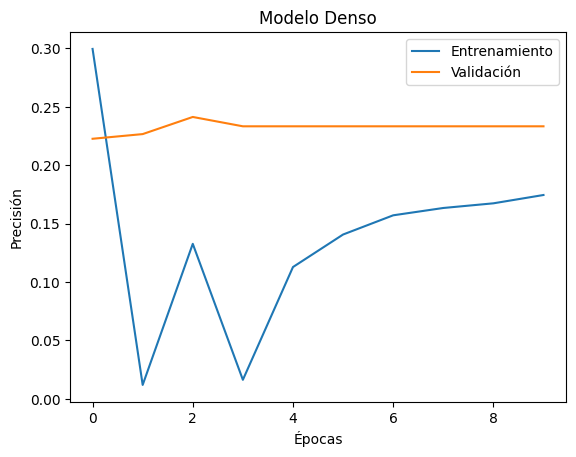

<Figure size 640x480 with 0 Axes>

In [ ]:
# Gráficos de cada modelo
plot_history(history_dense, 'Modelo Denso')

# Ajuste del diseño para que no haya solapamiento
plt.tight_layout()
plt.show()

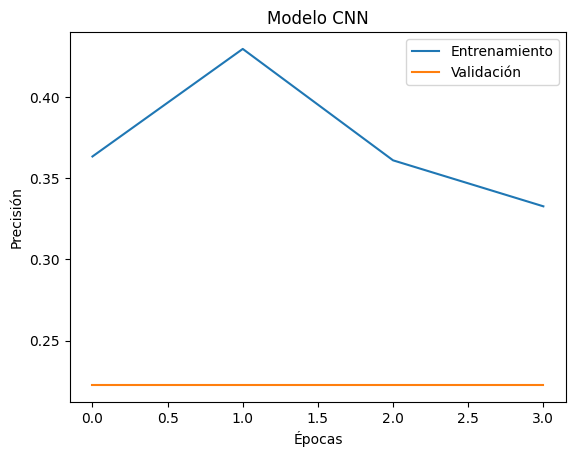

<Figure size 640x480 with 0 Axes>

In [ ]:
# Gráficos de cada modelo
plot_history(history_cnn, 'Modelo CNN')

# Ajuste del diseño para que no haya solapamiento
plt.tight_layout()
plt.show()

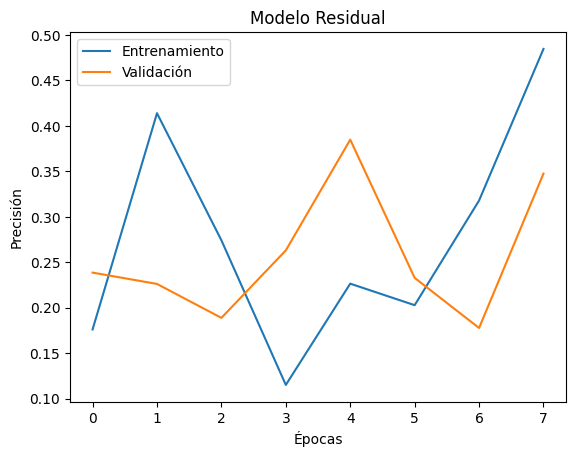

<Figure size 640x480 with 0 Axes>

In [20]:
# Gráficos de cada modelo
plot_history(history_residual, 'Modelo Residual')

# Ajuste del diseño para que no haya solapamiento
plt.tight_layout()
plt.show()

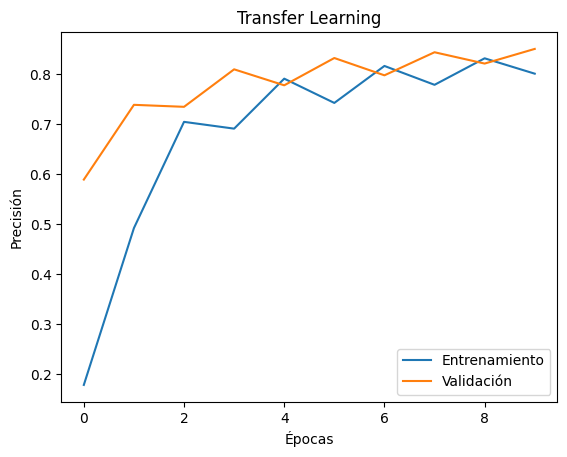

<Figure size 640x480 with 0 Axes>

In [ ]:
# Gráficos de cada modelo
plot_history(history_transfer, 'Transfer Learning')

# Ajuste del diseño para que no haya solapamiento
plt.tight_layout()
plt.show()

## CONCLUSIONES

Con respecto a las gráficas y las predicciones se puede concluir:

* El modelo denso presenta un comportamiento casi constante en validación, lo que implica que debe ser mejorada su arquitectura para poder entender mejor patrones de clasificación, además de más épocas. Sus predicciones no son buenas, con una precisión del 0.25 aprox.

* El modelo CNN presenta una tendencia a sobreajuste; aunque las épocas son pocas, esa tendencia podría desaparecer si se incrementan las épocas y los datos. Sus predicciones no son buenas, con una precisión del 0.25 aprox.

* El modelo de bloques residuales presenta un comportamiento más errático en train y validation. La métrica sigue siendo similar a los demás modelos mencionados, con una diferencia de 0.05 aprox. Faltarían más épocas y datos para mejorar el rendimiento del modelo.

* El modelo de transfer learning fue el mejor de los modelos, al tener un preentrenamiento, dio la precisión más alta. Con similar épocas y cantidad de datos tuvo más predicciones correctas y un entrenamiento más regular.